# Batch Document Extraction with InternVL3.5-8B (H200 + bfloat16)

**H200 REFERENCE VERSION**: This notebook uses bfloat16 precision to establish baseline performance on modern GPU architecture.

This notebook is designed to run on H200 GPU with native bfloat16 support for comparison with V100 float32 performance.

**Model**: InternVL3.5-8B (8.5B parameters: 0.3B vision + 8.2B language)

**Comparison Purpose**:
- **H200 + bfloat16**: Native hardware support, optimal performance (this notebook)
- **V100 + float32**: No bfloat16 support, requires full precision (ivl3_8b_batch.ipynb)

**Requirements**: 
- `transformers>=4.52.1` (critical for InternVL3.5 support)
- PyTorch with CUDA support
- H200/H100/A100 GPU (with native bfloat16 support)

**Key Features**:
- Cascade Reinforcement Learning (Cascade RL) for enhanced reasoning
- Visual Resolution Router (ViR) for dynamic resolution adjustment
- Flash Attention 2 enabled (H200 optimized)
- Improved performance over InternVL3 series

This notebook includes steps for:
* Loading documents
* Detecting document types  
* Extracting relevant information
* Generating reports
* **Comparing accuracy vs V100 to understand hardware impact**

## 1. Imports

In [1]:
#Cell 1
# Path setup for V100 systems - ensures proper module resolution
import sys
import os
from pathlib import Path
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'


# Get the notebook's directory
notebook_path = Path().absolute()
print(f"📂 Current directory: {notebook_path}")

# Ensure the project root is in the Python path
if str(notebook_path) not in sys.path:
    sys.path.insert(0, str(notebook_path))
    print(f"✅ Added {notebook_path} to sys.path")

# Verify common module can be found
try:
    import common
    print(f"✅ Common module found at: {common.__file__ if hasattr(common, '__file__') else 'built-in'}")
except ImportError as e:
    print(f"❌ Common module not found: {e}")
    print("📋 Current sys.path:")
    for p in sys.path[:5]:  # Show first 5 paths
        print(f"   - {p}")

print("✅ Path setup complete - proceed to imports")

📂 Current directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
✅ Common module found at: /home/jovyan/nfs_share/tod/LMM_POC/common/__init__.py
✅ Path setup complete - proceed to imports


## 2. Path Setup (V100 Compatibility)

**IMPORTANT**: If you encounter import errors on V100 systems, this cell ensures proper module resolution.

In [2]:
#Cell 2
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
import warnings
from datetime import datetime
from pathlib import Path

# Add current directory to path to ensure proper module resolution
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Third-party imports
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from rich import print as rprint
from rich.console import Console
from transformers import AutoModel, AutoTokenizer

# Project-specific imports - using absolute imports to avoid conflicts
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from models.document_aware_internvl3_processor import (
    DocumentAwareInternVL3HybridProcessor,
)

print("✅ All imports loaded successfully")
print("✅ InternVL3 Hybrid Processor imported successfully") 
print("✅ Batch processing modules imported successfully")
print(f"📂 Working directory: {notebook_dir}")
print("🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router")
warnings.filterwarnings('ignore')

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded successfully
✅ InternVL3 Hybrid Processor imported successfully
✅ Batch processing modules imported successfully
📂 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
🚀 InternVL3.5-8B: Cascade RL + Visual Resolution Router


## 3. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [3]:
#Cell 3
# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 4. Configuration

In [4]:
#Cell 4
# Initialize console and environment configuration
console = Console()

# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings - InternVL3.5-8B
    'MODEL_PATH': '/home/jovyan/nfs_share/models/InternVL3_5-8B',
    # Alternative paths:
    # 'MODEL_PATH': '/efs/shared/PTM/InternVL3_5-8B',
    # 'MODEL_PATH': 'OpenGVLab/InternVL3_5-8B',  # Auto-download from HuggingFace

    
    # Batch settings
    'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/synthetic_bank_images',
    'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/ground_truth_synthetic_bank.csv',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': False,  # Disable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: False (evaluation mode)
    
    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,
    
    # ============================================================================
    # H200 BFLOAT16 CONFIGURATION - OPTIMAL PERFORMANCE BASELINE
    # ============================================================================
    # This configuration uses H200's native bfloat16 support for optimal performance.
    # Compare against V100 float32 to understand hardware limitations impact.
    #
    # H200 advantages:
    # - Native bfloat16 hardware support (compute capability 9.0)
    # - Flash Attention 2 support for faster inference
    # - Higher memory bandwidth and capacity
    #
    # Configuration:
    # - bfloat16: Native hardware support, no conversion needed
    # - Flash Attention: Enabled for faster processing
    # - No quantization: Full precision for accuracy baseline
    # ============================================================================
    'USE_QUANTIZATION': False,  # Full precision for H200
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 2000,
    'TORCH_DTYPE': 'bfloat16',  # Native H200 support
    'LOW_CPU_MEM_USAGE': True,
    # Flash Attention: ENABLED for H200/H100/A100
    'USE_FLASH_ATTN': True  # H200 optimized - faster inference
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Explicit file and key mapping
# ============================================================================
# This configuration controls which prompt files and keys are used for each
# document type. You can explicitly override both the file and the key.
#
# Structure:
#   'extraction_files': Maps document types to YAML prompt files
#   'extraction_keys': (Optional) Maps document types to specific keys in those files
#
# If 'extraction_keys' is not specified for a document type, the key will be
# derived from the document type name (e.g., 'INVOICE' -> 'invoice')
#
# For bank statements, structure classification (_flat or _date_grouped) is 
# automatically appended UNLESS you provide a full key in 'extraction_keys'
# ============================================================================

PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': 'prompts/document_type_detection.yaml',
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': 'prompts/internvl3_prompts.yaml',
        'RECEIPT': 'prompts/internvl3_prompts.yaml', 
        'BANK_STATEMENT': 'prompts/internvl3_prompts.yaml'
    },
}

# Import field filtering from config to exclude validation-only fields
from common.config import get_v4_field_list, filter_evaluation_fields

# Get universal field list and filter out validation-only fields
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
# These fields are only for mathematical validation, not extraction/evaluation
UNIVERSAL_FIELDS = filter_evaluation_fields(get_v4_field_list())

print("✅ Configuration set up successfully")
print(f"📂 Evaluation data: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model: InternVL3.5-8B")
print(f"📁 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"📋 Universal fields: {len(UNIVERSAL_FIELDS)} (validation-only fields excluded)")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)")
print(f"⚡ Flash Attention: {'ENABLED (H200 optimized)' if CONFIG['USE_FLASH_ATTN'] else 'DISABLED'}")
print("🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution")
print("📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32")

✅ Configuration set up successfully
📂 Evaluation data: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images
📊 Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth_synthetic_bank.csv
🤖 Model: InternVL3.5-8B
📁 Model path: /home/jovyan/nfs_share/models/InternVL3_5-8B
📁 Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
📋 Universal fields: 14 (validation-only fields excluded)
🎯 Mode: Evaluation mode
⚙️  Precision: BFLOAT16 (H200 native support - optimal performance)
⚡ Flash Attention: ENABLED (H200 optimized)
🚀 InternVL3.5-8B: Enhanced reasoning and dynamic resolution
📊 COMPARISON MODE: Establish H200 bfloat16 baseline vs V100 float32


# 5. Output Directory Setup

In [5]:
#Cell 5
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

# 6. Model Loading

**InternVL3.5-8B**: Loading the latest InternVL3.5 model with Cascade RL and Visual Resolution Router.

**Requirements**: Ensure `transformers>=4.52.1` is installed for InternVL3.5 compatibility.

In [6]:
#Cell 6
# Load InternVL3.5 model using official pattern
# Model page: https://huggingface.co/OpenGVLab/InternVL3_5-8B
rprint("[bold green]Loading InternVL3.5-8B model...[/bold green]")
rprint("[cyan]🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)[/cyan]")
rprint("[cyan]📖 Features: Cascade RL, Visual Resolution Router (ViR)[/cyan]")

try:
    # Clear any existing CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        rprint("[blue]🧹 CUDA cache cleared[/blue]")
    
    # Load model using official InternVL3.5 pattern
    rprint("[cyan]📥 Loading model with official parameters...[/cyan]")
    model = AutoModel.from_pretrained(
        CONFIG['MODEL_PATH'],
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
        use_flash_attn=CONFIG['USE_FLASH_ATTN'],
        trust_remote_code=True,
        device_map="auto"  # Distribute across available GPUs
    ).eval()
    
    # Load tokenizer
    rprint("[cyan]📥 Loading tokenizer...[/cyan]")
    tokenizer = AutoTokenizer.from_pretrained(
        CONFIG['MODEL_PATH'],
        trust_remote_code=True,
        use_fast=False
    )
    
    # Set generation parameters
    model.config.max_new_tokens = CONFIG['MAX_NEW_TOKENS']
    
    # Display model information
    rprint("[green]✅ Model and tokenizer loaded successfully![/green]")
    
    # ============================================================================
    # BEAUTIFUL MULTI-GPU MEMORY DISPLAY (matching llama_batch.ipynb)
    # ============================================================================
    if torch.cuda.is_available():
        device_count = torch.cuda.device_count()
        
        if device_count > 1:
            # Multi-GPU detailed breakdown
            rprint(f"[blue]🔄 Multi-GPU Distribution Analysis ({device_count} GPUs):[/blue]")
            
            total_allocated = 0
            total_reserved = 0
            total_capacity = 0
            
            for gpu_id in range(device_count):
                gpu_allocated = torch.cuda.memory_allocated(gpu_id) / 1e9
                gpu_reserved = torch.cuda.memory_reserved(gpu_id) / 1e9
                gpu_capacity = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9
                gpu_name = torch.cuda.get_device_name(gpu_id)
                
                total_allocated += gpu_allocated
                total_reserved += gpu_reserved
                total_capacity += gpu_capacity
                
                usage_pct = (gpu_allocated / gpu_capacity) * 100 if gpu_capacity > 0 else 0
                rprint(f"   GPU {gpu_id} ({gpu_name}): {gpu_allocated:.1f}GB/{gpu_capacity:.0f}GB ({usage_pct:.1f}%)")
            
            rprint(f"[blue]📊 Total across all GPUs: {total_allocated:.1f}GB allocated, {total_reserved:.1f}GB reserved, {total_capacity:.0f}GB capacity[/blue]")
            
            if hasattr(model, 'hf_device_map'):
                from collections import Counter
                device_distribution = Counter(model.hf_device_map.values())
                rprint(f"[green]✅ Model successfully distributed: {dict(device_distribution)}[/green]")
        else:
            # Single GPU
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            total = torch.cuda.get_device_properties(0).total_memory / 1e9
            gpu_name = torch.cuda.get_device_name(0)
            usage_pct = (allocated / total) * 100 if total > 0 else 0
            
            rprint(f"[blue]📊 GPU {gpu_name}: {allocated:.1f}GB/{total:.0f}GB ({usage_pct:.1f}%)[/blue]")
    
    # ============================================================================
    # BEAUTIFUL CONFIGURATION TABLE (matching llama_batch.ipynb)
    # ============================================================================
    from rich.table import Table
    
    config_table = Table(title="🔧 InternVL3.5-8B Model Configuration")
    config_table.add_column("Setting", style="cyan")
    config_table.add_column("Value", style="yellow")
    config_table.add_column("Status", style="green")
    
    # Model path
    model_name = Path(CONFIG['MODEL_PATH']).name
    config_table.add_row("Model Path", model_name, "✅ Valid")
    
    # Model type
    config_table.add_row("Model Type", "InternVL3.5-8B", "✅ Cascade RL + ViR")
    
    # Device placement
    config_table.add_row("Device Placement", str(next(model.parameters()).device), "✅ Loaded")
    
    # Quantization
    quant_status = "✅ 16-bit (Performance Optimized)" if not CONFIG['USE_QUANTIZATION'] else "✅ 8-bit (Memory Optimized)"
    quant_method = "16-bit" if not CONFIG['USE_QUANTIZATION'] else "8-bit"
    config_table.add_row("Quantization Method", quant_method, quant_status)
    
    # Data type
    config_table.add_row("Data Type", str(CONFIG['TORCH_DTYPE']), "✅ Recommended")
    
    # Max new tokens
    config_table.add_row("Max New Tokens", str(CONFIG['MAX_NEW_TOKENS']), "✅ Generation Ready")
    
    # GPU configuration
    if torch.cuda.is_available():
        if device_count > 1:
            gpu_info = f"{device_count}x {torch.cuda.get_device_name(0)} ({total_capacity:.0f}GB)"
            gpu_status = f"✅ {total_capacity:.0f}GB Total"
        else:
            gpu_info = f"{torch.cuda.get_device_name(0)} ({total:.0f}GB)"
            gpu_status = "✅ Single GPU"
    else:
        gpu_info = "CPU"
        gpu_status = "💻 CPU Mode"
    config_table.add_row("GPU Configuration", gpu_info, gpu_status)
    
    # Model parameters
    param_count = sum(p.numel() for p in model.parameters())
    config_table.add_row("Model Parameters", f"{param_count:,}", "✅ Loaded")
    
    # Flash Attention
    flash_attn_status = "✅ Enabled" if CONFIG['USE_FLASH_ATTN'] else "⚠️ Disabled"
    config_table.add_row("Flash Attention", str(CONFIG['USE_FLASH_ATTN']), flash_attn_status)
    
    console.print(config_table)
    
    # Initialize the hybrid processor with loaded model components
    rprint("[cyan]🔧 Initializing document-aware processor...[/cyan]")
    hybrid_processor = DocumentAwareInternVL3HybridProcessor(
        field_list=UNIVERSAL_FIELDS,
        model_path=CONFIG['MODEL_PATH'],
        debug=CONFIG['VERBOSE'],
        pre_loaded_model=model,
        pre_loaded_tokenizer=tokenizer,
        prompt_config=PROMPT_CONFIG
    )
    
    rprint("[bold green]✅ InternVL3.5-8B ready for document-aware processing[/bold green]")
    rprint("[cyan]🎯 Enhanced with Cascade RL for improved reasoning[/cyan]")
    
except Exception as e:
    rprint(f"[red]❌ Error loading model: {e}[/red]")
    rprint("[yellow]💡 Ensure transformers>=4.52.1 is installed[/yellow]")
    rprint("[yellow]💡 Check model path is correct[/yellow]")
    raise

Loading InternVL3.5-8B model...

🚀 Model: InternVL3.5-8B (8.5B params: 0.3B vision + 8.2B language)

📖 Features: Cascade RL, Visual Resolution Router (ViR)

🧹 CUDA cache cleared

📥 Loading model with official parameters...

`torch_dtype` is deprecated! Use `dtype` instead!


FlashAttention2 is not installed.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

📥 Loading tokenizer...

✅ Model and tokenizer loaded successfully!

🔄 Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA L40S): 8.0GB/48GB (16.8%)

GPU 1 (NVIDIA L40S): 9.0GB/48GB (18.9%)

📊 Total across all GPUs: 17.1GB allocated, 17.1GB reserved, 96GB capacity

✅ Model successfully distributed: {0: 18, 1: 24}

                       🔧 InternVL3.5-8B Model Configuration                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                 ┃ Status                            ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ InternVL3_5-8B        │ ✅ Valid                          │
│ Model Type          │ InternVL3.5-8B        │ ✅ Cascade RL + ViR               │
│ Device Placement    │ cuda:0                │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16              │ ✅ Recommended                    │
│ Max New Tokens      │ 2000                  │ ✅ Generation Ready               │
│ GPU Configuration   │ 2x NVIDIA L40S (96GB) │ ✅ 96GB Total                     │
│ Model Parameters    │ 8,528,318,464         │ ✅ Loaded                         │
│ Flash Attention     │ True                  │ ✅ Enabled                        │
└─────────────────────┴───────────────────────┴───────────────────────────────────┘

🔧 Initializing document-aware processor...

🎯 InternVL3 Hybrid processor initialized for 14 fields: DOCUMENT_TYPE → TOTAL_AMOUNT
🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=15.89GB, Reserved=15.93GB
🤖 Auto-detected batch size: 8 (GPU Memory: 73.1GB)
🎯 DOCUMENT AWARE REDUCTION: 14 fields (~52% fewer than original 29)
🎯 Generation config: max_new_tokens=2000, do_sample=False (greedy decoding)
✅ Using pre-loaded InternVL3 model and tokenizer
🔧 Device: cuda:0
💾 Model parameters: 8,528,318,464
🚀 V100 optimizations applied


✅ InternVL3.5-8B ready for document-aware processing

🎯 Enhanced with Cascade RL for improved reasoning

# 7. Image Discovery

In [7]:
#Cell 7
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic_bank_images

Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth_synthetic_bank.csv

Mode: Evaluation mode

  1. cba_amount_balance.png
  2. cba_date_grouped.png
  3. cba_date_grouped_cont.png
  4. cba_debit_credit.png
  5. cba_highligted.png
  ... and 4 more


## 8. Batch Processing

In [8]:
#Cell 8
# Initialize batch processor with proven infrastructure (same pattern as llama_batch.ipynb)
processor = BatchDocumentProcessor(
    model=hybrid_processor,  # InternVL3 hybrid processor (handler)
    processor=None,          # Not needed for InternVL3
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# Process batch using proven evaluation infrastructure
batch_results, processing_times, document_types_found = processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

📋 Sample GT keys: ['cba_date_grouped.png', 'cba_date_grouped_cont.png', 'transaction_summary.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/9]: cba_amount_balance.png

🔍 TRACE: Processing InternVL3 image 1/9: cba_amount_balance.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_amount_balance.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📝 Using bank_statement_flat prompt (prompt_config): 1935 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_amount_balance.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'FLAT'

🧠 Analysis: date_indicators=False, flat_indicators=True

📊 Triggered flat indicators: ['FLAT']

📋 Classification Result: FLAT

Description: Continuous table format with column headers

💡 Will use flat table extraction prompt

🏗️ Bank statement structure: flat

📝 Using prompt key: bank_statement_flat

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_flat'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_flat'

📝 Loading bank_statement_flat prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_flat'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (1935 chars):

================================================================================

Extract structured data from this flat table bank statement for taxpayer expense claims.

STEP 1 - LOCATE TRANSACTION TABLE:
Focus on the main transaction table (usually center/body area).
Columns: Date | Description | Debit/Withdrawal | Credit/Deposit | Balance
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
TARGET COLUMNS: Date + Description + Debit/Withdrawal amount

For each row check:
- Has value in DEBIT/WITHDRAWAL column? → Extract this row
- Has value in CREDIT/DEPOSIT column only? → SKIP this row
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received

STEP 3 - EXTRACT ROW-BY-ROW:
For EACH debit row:
1. Extract DATE (DD/MM/YYYY format)
2. Extract DESCRIPTION (exact text)
3. Extract AMOUNT (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries
- Process chronologically (top to bottom)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any row with value in CREDIT/DEPOSIT column
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Date range like "01/01/2025 to 31/01/2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing fields

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (801 chars):

================================================================================

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE CENTRAL T 
54321F SUBURB AUS | CAFE CENTRAL T 54321F SUBURB AUS | ONLINE RETAILER.COM SYDNEY AU AUS | SERVICE STATION SUBURB 
NS AUS | SERVICE STATION SUBURB NS AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | 
ELECTRONICS 9876 SUBURB NSW AUS | PHARMACY SERVICES MELBOURNE AUS | BOOKSTORE 2345 SYDNEY AU
TRANSACTION_DATES: 03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 | 08/06/2023 | 
09/06/2023 | 09/06/2023 | 10/06/2023 | 12/06/2023 | 14/06/2023
TRANSACTION_AMOUNTS_PAID: $78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00 | $145.50 | 
$567.30 | $42.85 | $234.90

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS |
CAFE CENTRAL T 54321F SUBURB...' -> 'GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE 
CENTRAL T 54321F SUBURB...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 
| 08/06/2023 | 09/06/202...' -> '03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 | 
08/06/2023 | 09/06/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | 
$89.00 | $145.50 | $567.30 | $42.85 ...' -> '$78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00
| $145.50 | $567.30 | $42.85 ...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE CENTRAL 
T 54321F SUBURB AUS | CAFE CENTRAL T 54321F SUBURB AUS | ONLINE RETAILER.COM SYDNEY AU AUS | SERVICE STATION SUBURB
NS AUS | SERVICE STATION SUBURB NS AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | 
ELECTRONICS 9876 SUBURB NSW AUS | PHARMACY SERVICES MELBOURNE AUS | BOOKSTORE 2345 SYDNEY AU"

✅ TRANSACTION_DATES: "03/06/2023 | 04/06/2023 | 06/06/2023 | 06/06/2023 | 07/06/2023 | 08/06/2023 | 08/06/2023 |
09/06/2023 | 09/06/2023 | 10/06/2023 | 12/06/2023 | 14/06/2023"

✅ TRANSACTION_AMOUNTS_PAID: "$78.90 | $345.80 | $24.50 | $31.20 | $18.95 | $95.40 | $28.60 | $89.00 | $145.50 | 
$567.30 | $42.85 | $234.90"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.50GB allocated, 7.51GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_amount_balance.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from cba_amount_balance.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 99.1% for cba_amount_balance.png

  Precision: 100.0% | Recall: 98.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [2/9]: cba_date_grouped.png

🔍 TRACE: Processing InternVL3 image 2/9: cba_date_grouped.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (762 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: 15/03/2024 to 14/04/2024
LINE_ITEM_DESCRIPTIONS: TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS | SHELL SERVICE 
STATION RICHMOND VIC | NETFLIX SUBSCRIPTION | Transfer from xx7876 CommBank app | CAFE LATTE FITZROY VIC AUS | 
COLES SUPERMARKET CARLTON VIC | PARKING METERS MELBOURNE VIC | RENT PAYMENT REAL ESTATE | Transfer from xx8765 
CommBank app | CHEMIST WAREHOUSE MELBOURNE VIC
TRANSACTION_DATES: 18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 25/03/2024 | 28/03/2024 | 05/04/2024 | 
08/04/2024 | 10/04/2024 | 12/04/2024 | 14/04/2024
TRANSACTION_AMOUNTS_PAID: $48.50 | $127.35 | $89.60 | $22.99 | $500.00 | $18.50 | $156.78 | $15.00 | $1,850.00 | 
$75.00 | $54.64
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: STATEMENT_DATE_RANGE: '15/03/2024 to 14/04/2024' -> '15/03/2024 to 14/04/2024'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS 
| SHELL SERVICE STATION RICHM...' -> 'TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS | 
SHELL SERVICE STATION RICHM...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 25/03/2024 | 28/03/2024 
| 05/04/2024 | 08/04/202...' -> '18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 25/03/2024 | 28/03/2024 | 
05/04/2024 | 08/04/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$48.50 | $127.35 | $89.60 | $22.99 | $500.00 | $18.50 | $156.78 | 
$15.00 | $1,850.00 | $75.00 | $54....' -> '$48.50 | $127.35 | $89.60 | $22.99 | $500.00 | $18.50 | $156.78 | $15.00
| $1,850.00 | $75.00 | $54....'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

✅ STATEMENT_DATE_RANGE: "15/03/2024 to 14/04/2024"

✅ LINE_ITEM_DESCRIPTIONS: "TELSTRA MOBILE SERVICES SYDNEY AUS | WOOLWORTHS 2847 MELBOURNE VIC AUS | SHELL 
SERVICE STATION RICHMOND VIC | NETFLIX SUBSCRIPTION | Transfer from xx7876 CommBank app | CAFE LATTE FITZROY VIC 
AUS | COLES SUPERMARKET CARLTON VIC | PARKING METERS MELBOURNE VIC | RENT PAYMENT REAL ESTATE | Transfer from 
xx8765 CommBank app | CHEMIST WAREHOUSE MELBOURNE VIC"

✅ TRANSACTION_DATES: "18/03/2024 | 19/03/2024 | 20/03/2024 | 22/03/2024 | 25/03/2024 | 28/03/2024 | 05/04/2024 |
08/04/2024 | 10/04/2024 | 12/04/2024 | 14/04/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$48.50 | $127.35 | $89.60 | $22.99 | $500.00 | $18.50 | $156.78 | $15.00 | 
$1,850.00 | $75.00 | $54.64"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 5/7 fields

Found: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.49GB allocated, 7.51GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 5/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_date_grouped.png, doc_type=BANK_STATEMENT

✓ Extracted 5 fields from cba_date_grouped.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 57.7% for cba_date_grouped.png

  Precision: 77.1% | Recall: 48.8%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [3/9]: cba_date_grouped_cont.png

🔍 TRACE: Processing InternVL3 image 3/9: cba_date_grouped_cont.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped_cont.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_date_grouped_cont.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (851 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | GYM MEMBERSHIP 
FITNESS FIRST VIC AU A | AUTO SERVICES BRUNSWICK AU AUS | HARDWARE STORE BUNNINGS VIC AU | ELECTRONICS STORE JB HI 
FI AU AUS | PHARMACY CHEMIST MELBOURNE VIC | DIRECT DEBIT INSURANCE PREMIUM | STREAMING SERVICE SPOTIFY AUS | PET 
SUPPLIES PETBARN RICHMOND VIC | UTILITIES ELECTRICITY BILL | DEPARTMENT STORE MYERS VIC AU",
  "TRANSACTION_DATES": "16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 | 08/05/2024 | 
10/05/2024 | 14/05/2024 | 16/05/2024 | 22/05/2024 | 26/05/2024",
  "TRANSACTION_AMOUNTS_PAID": "$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | $85.50 | $14.99 |
$98.75 | $178.60 | $234.90"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | 
GYM MEMBERSHIP FITNESS FIRST V...' -> 'RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | GYM 
MEMBERSHIP FITNESS FIRST V...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 
| 08/05/2024 | 10/05/202...' -> '16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 | 
08/05/2024 | 10/05/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | 
$85.50 | $14.99 | $98.75 | $178.6...' -> '$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | $85.50
| $14.99 | $98.75 | $178.6...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "RESTAURANT DINING SOUTH BANK VIC A | BOOKSTORE MELBOURNE CBD AU AUS | GYM MEMBERSHIP 
FITNESS FIRST VIC AU A | AUTO SERVICES BRUNSWICK AU AUS | HARDWARE STORE BUNNINGS VIC AU | ELECTRONICS STORE JB HI 
FI AU AUS | PHARMACY CHEMIST MELBOURNE VIC | DIRECT DEBIT INSURANCE PREMIUM | STREAMING SERVICE SPOTIFY AUS | PET 
SUPPLIES PETBARN RICHMOND VIC | UTILITIES ELECTRICITY BILL | DEPARTMENT STORE MYERS VIC AU"

✅ TRANSACTION_DATES: "16/04/2024 | 18/04/2024 | 20/04/2024 | 22/04/2024 | 26/04/2024 | 28/04/2024 | 08/05/2024 |
10/05/2024 | 14/05/2024 | 16/05/2024 | 22/05/2024 | 26/05/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$185.00 | $67.40 | $79.99 | $245.00 | $124.85 | $399.00 | $42.30 | $85.50 | $14.99 
| $98.75 | $178.60 | $234.90"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.49GB allocated, 7.51GB reserved

✅ Final GPU memory: 7.49GB allocated, 7.51GB reserved

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_date_grouped_cont.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from cba_date_grouped_cont.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 67.9% for cba_date_grouped_cont.png

  Precision: 100.0% | Recall: 58.9%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [4/9]: cba_debit_credit.png

🔍 TRACE: Processing InternVL3 image 4/9: cba_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (955 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING SUBURB 
AU | SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer to financially sorted 
| GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY LTD 
SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD 
Suburb VICAU | Afterpay afterpay.com AU AUS
TRANSACTION_DATES: 20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 
22/05/2024 | 22/05/2024 | 22/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 24/05/2024
TRANSACTION_AMOUNTS_PAID: $178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | $124.00 | $78.90 | 
$56.40 | $1,456.80 | $67.75 | $89.25 | $45.80 | $234.90
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | 
SUPERMARKET SHOPPING SUBURB AU | SHOPP...' -> 'Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | 
SUPERMARKET SHOPPING SUBURB AU | SHOPP...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 
| 21/05/2024 | 22/05/202...' -> '20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 
21/05/2024 | 22/05/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | 
$124.00 | $78.90 | $56.40 | $1,45...' -> '$178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | 
$124.00 | $78.90 | $56.40 | $1,45...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING 
SUBURB AU | SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer to financially 
sorted | GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY 
LTD SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD
Suburb VICAU | Afterpay afterpay.com AU AUS"

✅ TRANSACTION_DATES: "20/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 | 21/05/2024 |
22/05/2024 | 22/05/2024 | 22/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 23/05/2024 | 24/05/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | $124.00 | $78.90
| $56.40 | $1,456.80 | $67.75 | $89.25 | $45.80 | $234.90"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.49GB allocated, 7.51GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_debit_credit.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from cba_debit_credit.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 98.0% for cba_debit_credit.png

  Precision: 100.0% | Recall: 96.2%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [5/9]: cba_highligted.png

🔍 TRACE: Processing InternVL3 image 5/9: cba_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: cba_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the bank statement are organized in a continuous table format with column headers. Each 
transaction has its own individual date value, and there are no date section headers breaking up the table. The 
layout is flat, with a'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([10, 3, 448, 448]) (batch_size=10 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([10, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (236 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "NOT_FOUND",
  "TRANSACTION_DATES": "24/03/2024 | 30/03/2024",
  "TRANSACTION_AMOUNTS_PAID": "$1,285.65 | $4,200.00"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: TRANSACTION_DATES: '24/03/2024 | 30/03/2024' -> '24/03/2024 | 30/03/2024'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$1,285.65 | $4,200.00' -> '$1,285.65 | $4,200.00'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

❌ LINE_ITEM_DESCRIPTIONS: "NOT_FOUND"

✅ TRANSACTION_DATES: "24/03/2024 | 30/03/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$1,285.65 | $4,200.00"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 3/7 fields

Found: ['DOCUMENT_TYPE', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID']

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.50GB allocated, 7.51GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 3/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for cba_highligted.png, doc_type=BANK_STATEMENT

✓ Extracted 3 fields from cba_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 40.0% for cba_highligted.png

  Precision: 40.0% | Recall: 40.0%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[5/9] cba_highligted.png: BANK_STATEMENT - Accuracy: 40.0% - Time: 14.99s

Processing [6/9]: low_contrast.png

🔍 TRACE: Processing InternVL3 image 6/9: low_contrast.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: low_contrast.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: low_contrast.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([13, 3, 448, 448]) (batch_size=13 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([13, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (1074 chars):

================================================================================

```json
{
  "DOCUMENT_TYPE": "BANK_STATEMENT",
  "STATEMENT_DATE_RANGE": "NOT_FOUND",
  "LINE_ITEM_DESCRIPTIONS": "Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | Otr Convenience
4321 Melbourne Aus | Retailstore 8765 Perth Aus | Otr Convenience 4321 Melbourne Aus | Valley Shopping Ct Brisbane 
Aus | Plaza Hotel Sydney Sydney Cre Aus | Plaza Hotel Sydney Sydney Cre Aus | Department Store Pl Adelaide Aus | 
Plaza Motorcycle Brisbane Aus | Plaza Hotel Sydney Sydney Cre Aus | Value Retail Pty Newcastle South Aus | Office 
Supplies Brisbane Aus | Valley Shop Brisbane Aus | Brisbane Store Brisbane Aus | Value Family Trust Brisbane Aus",
  "TRANSACTION_DATES": "05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 
07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 08/09/2023 | 08/09/2023 | 09/09/2023 | 
10/09/2023",
  "TRANSACTION_AMOUNTS_PAID": "$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50 | $156.95 | 
$245.00 | $389.00 | $12.80 | $78.45 | $45.30 | $23.90 | $890.00"
}
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | 
Otr Convenience 4321 Melbourn...' -> 'Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | Otr 
Convenience 4321 Melbourn...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 
| 07/09/2023 | 07/09/202...' -> '05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 
07/09/2023 | 07/09/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50
| $156.95 | $245.00 | $389.00 ...' -> '$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50 | 
$156.95 | $245.00 | $389.00 ...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Otr Supermarket 9876 Sydney Aus | Otr Convenience 4321 Melbourne Aus | Otr 
Convenience 4321 Melbourne Aus | Retailstore 8765 Perth Aus | Otr Convenience 4321 Melbourne Aus | Valley Shopping 
Ct Brisbane Aus | Plaza Hotel Sydney Sydney Cre Aus | Plaza Hotel Sydney Sydney Cre Aus | Department Store Pl 
Adelaide Aus | Plaza Motorcycle Brisbane Aus | Plaza Hotel Sydney Sydney Cre Aus | Value Retail Pty Newcastle South
Aus | Office Supplies Brisbane Aus | Valley Shop Brisbane Aus | Brisbane Store Brisbane Aus | Value Family Trust 
Brisbane Aus"

✅ TRANSACTION_DATES: "05/09/2023 | 06/09/2023 | 06/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 |
07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 07/09/2023 | 08/09/2023 | 08/09/2023 | 09/09/2023 | 10/09/2023"

✅ TRANSACTION_AMOUNTS_PAID: "$45.80 | $28.45 | $15.90 | $12.35 | $34.60 | $67.00 | $89.00 | $23.50 | $156.95 | 
$245.00 | $389.00 | $12.80 | $78.45 | $45.30 | $23.90 | $890.00"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.50GB allocated, 7.51GB reserved

✅ Final GPU memory: 7.50GB allocated, 7.51GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for low_contrast.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from low_contrast.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 96.5% for low_contrast.png

  Precision: 98.5% | Recall: 94.8%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [7/9]: nab_classic_highligted.png

🔍 TRACE: Processing InternVL3 image 7/9: nab_classic_highligted.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a BANK_STATEMENT.

🔍 PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: nab_classic_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: This is a BANK_STATEMENT.

🔍 PARSING DEBUG - Raw response: 'This is a BANK_STATEMENT.'

🔍 PARSING DEBUG - Cleaned response: 'this is a bank_statement.'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: nab_classic_highligted.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 'This is a 
BANK_STATEMENT.', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (965 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: EFTPOS 18/06 Fresh Groceries | V1056 18/06 Farmland Markets | Pizza Delivery | V1056 16/06 
Gas Station 890000 | Auto Repair | V1056 20/06 The Restaurant | V1056 Farmland Markets | V1056 20/06 City Square | 
V1056 20/06 The Restaurant | V1056 Depot Retail No | V1056 21/06 Shopping Complex | V1056 Retail Parkchester Rd 
Beer | V1056 19/06 Fast Food Chain North | V1056 22/06 Market Street | V1056 24/06 Retail & Fashion | V1056 21/06 
Department Plaza
TRANSACTION_DATES: 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 24/03/2024 | 24/03/2024 | 
24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 25/03/2024 
| 25/03/2024
TRANSACTION_AMOUNTS_PAID: $89.75 | $45.50 | $125.00 | $78.40 | $345.60 | $67.80 | $56.90 | $234.50 | $89.60 | 
$145.80 | $267.40 | $78.90 | $45.80 | $123.60 | $189.50 | $356.20
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'EFTPOS 18/06 Fresh Groceries | V1056 18/06 Farmland Markets | Pizza 
Delivery | V1056 16/06 Gas Stati...' -> 'EFTPOS 18/06 Fresh Groceries | V1056 18/06 Farmland Markets | Pizza 
Delivery | V1056 16/06 Gas Stati...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 24/03/2024 
| 24/03/2024 | 24/03/202...' -> '23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 24/03/2024 | 
24/03/2024 | 24/03/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$89.75 | $45.50 | $125.00 | $78.40 | $345.60 | $67.80 | $56.90 | 
$234.50 | $89.60 | $145.80 | $267.4...' -> '$89.75 | $45.50 | $125.00 | $78.40 | $345.60 | $67.80 | $56.90 | 
$234.50 | $89.60 | $145.80 | $267.4...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "EFTPOS 18/06 Fresh Groceries | V1056 18/06 Farmland Markets | Pizza Delivery | V1056 
16/06 Gas Station 890000 | Auto Repair | V1056 20/06 The Restaurant | V1056 Farmland Markets | V1056 20/06 City 
Square | V1056 20/06 The Restaurant | V1056 Depot Retail No | V1056 21/06 Shopping Complex | V1056 Retail 
Parkchester Rd Beer | V1056 19/06 Fast Food Chain North | V1056 22/06 Market Street | V1056 24/06 Retail & Fashion 
| V1056 21/06 Department Plaza"

✅ TRANSACTION_DATES: "23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 23/03/2024 | 24/03/2024 | 24/03/2024 |
24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 24/03/2024 | 25/03/2024 
| 25/03/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$89.75 | $45.50 | $125.00 | $78.40 | $345.60 | $67.80 | $56.90 | $234.50 | $89.60 |
$145.80 | $267.40 | $78.90 | $45.80 | $123.60 | $189.50 | $356.20"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

📊 Initial GPU memory: 7.49GB allocated, 7.51GB reserved

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for nab_classic_highligted.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from nab_classic_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 55.2% for nab_classic_highligted.png

  Precision: 60.0% | Recall: 52.2%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [8/9]: transaction_summary.png

🔍 TRACE: Processing InternVL3 image 8/9: transaction_summary.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([9, 3, 448, 448]) (batch_size=9 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([9, 3, 448, 448]) (batch_size=9 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the image are organized in a continuous table format with column headers. Each transaction has 
its own individual date value, and there are no date section headers breaking up the table. The layout is flat, 
with a clear'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([9, 3, 448, 448]) (batch_size=9 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: transaction_summary.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([9, 3, 448, 448]) (batch_size=9 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'Response: FLAT

The transactions in the image are organized in a continuous table format with column headers. Each transaction has 
its own individual date value, and there are no date section headers breaking up the table. The layout is flat, 
with a clear'

🧠 Analysis: date_indicators=True, flat_indicators=True

📅 Triggered date indicators: ['DATE', 'SECTION', 'HEADER', 'ORGANIZE']

📊 Triggered flat indicators: ['FLAT', 'TABLE', 'COLUMN', 'CONTINUOUS']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([9, 3, 448, 448]) (batch_size=9 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([9, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (708 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: GROCERY STORE | ONLINE RETAILER | International Transaction Fee | ELECTRONICS.COM | 
SUBSCRIPTION SERVICE | International Transaction Fee | DEPARTMENT STORE | International Transaction Fee | Monthly 
Account Fee | RESTAURANT | Payment | Instalment Payment | Instalment Payment
TRANSACTION_DATES: 25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 | 15/03/2024 | 
15/03/2024 | 18/03/2024 | 22/03/2024 | 28/03/2024 | 30/03/2024 | 02/04/2024
TRANSACTION_AMOUNTS_PAID: $127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | $3.56 | $12.95 | $178.50
| $685.00 | $45.20 | $128.75
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'GROCERY STORE | ONLINE RETAILER | International Transaction Fee | 
ELECTRONICS.COM | SUBSCRIPTION SER...' -> 'GROCERY STORE | ONLINE RETAILER | International Transaction Fee | 
ELECTRONICS.COM | SUBSCRIPTION SER...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 
| 15/03/2024 | 15/03/202...' -> '25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 | 
15/03/2024 | 15/03/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | 
$3.56 | $12.95 | $178.50 | $685.00 ...' -> '$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | $3.56 
| $12.95 | $178.50 | $685.00 ...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "GROCERY STORE | ONLINE RETAILER | International Transaction Fee | ELECTRONICS.COM | 
SUBSCRIPTION SERVICE | International Transaction Fee | DEPARTMENT STORE | International Transaction Fee | Monthly 
Account Fee | RESTAURANT | Payment | Instalment Payment | Instalment Payment"

✅ TRANSACTION_DATES: "25/02/2024 | 27/02/2024 | 27/02/2024 | 08/03/2024 | 12/03/2024 | 12/03/2024 | 15/03/2024 |
15/03/2024 | 18/03/2024 | 22/03/2024 | 28/03/2024 | 30/03/2024 | 02/04/2024"

✅ TRANSACTION_AMOUNTS_PAID: "$127.85 | $245.60 | $2.46 | $189.99 | $24.95 | $0.25 | $356.40 | $3.56 | $12.95 | 
$178.50 | $685.00 | $45.20 | $128.75"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ Final GPU memory: 7.49GB allocated, 7.51GB reserved

💾 Memory freed: 0.00GB

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for transaction_summary.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from transaction_summary.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 58.6% for transaction_summary.png

  Precision: 66.3% | Recall: 54.5%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

Processing [9/9]: westpac_debit_credit.png

🔍 TRACE: Processing InternVL3 image 9/9: westpac_debit_credit.png

📋 INTERNVL3 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 CONFIG DEBUG - Using prompt_config: detection_key='detection'

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

✅ Detected Document Type: BANK_STATEMENT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 INTERNVL3 DOCUMENT-AWARE EXTRACTION (BANK_STATEMENT)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Processing BANK_STATEMENT document with InternVL3

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: westpac_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📝 Using bank_statement_date_grouped prompt (prompt_config): 2178 characters

🔍 Using InternVL3 document detection prompt: detection

📝 Prompt: What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, esti...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🤖 Model response: BANK_STATEMENT (includes credit card statements)

🔍 PARSING DEBUG - Raw response: 'BANK_STATEMENT (includes credit card statements)'

🔍 PARSING DEBUG - Cleaned response: 'bank_statement (includes credit card statements)'

✅ PARSING DEBUG - Found mapping: 'bank_statement' -> 'BANK_STATEMENT'

✅ Detected document type: BANK_STATEMENT

🔍 Running vision-based structure classification for bank statement

🔍 Analyzing bank statement structure: westpac_debit_credit.png

🤖 Using VLM for structure analysis...

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

📋 VLM response: 'DATE_GROUPED'

🧠 Analysis: date_indicators=True, flat_indicators=False

📅 Triggered date indicators: ['DATE', 'GROUPED']

📋 Classification Result: DATE_GROUPED

Description: Transactions grouped under date section headers

💡 Will use date-grouped extraction prompt

🏗️ Bank statement structure: date_grouped

📝 Using prompt key: bank_statement_date_grouped

📋 DOCUMENT DETECTION RESULT: {'document_type': 'BANK_STATEMENT', 'confidence': 1.0, 'raw_response': 
'BANK_STATEMENT (includes credit card statements)', 'prompt_used': 'detection'}

🎯 DETECTED DOCUMENT TYPE: 'BANK_STATEMENT' → MAPPED TO: 'bank_statement_date_grouped'

📝 LOADING EXTRACTION PROMPT FOR: 'bank_statement_date_grouped'

📝 Loading bank_statement_date_grouped prompt for InternVL3 Hybrid

📋 DOCUMENT-SPECIFIC FIELDS: 7 fields for 'bank_statement_date_grouped'

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES', 
'TRANSACTION_AMOUNTS_PAID']...

📝 Generated prompt for 14 fields

Fields: ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE', 'LINE_ITEM_DESCRIPTIONS']...

🔍 DOCUMENT-AWARE PROMPT (2178 chars):

================================================================================

Extract structured data from this date-grouped bank statement for taxpayer expense claims.

STEP 1 - LOCATE DATE-GROUPED SECTIONS:
Focus on main transaction area in document body.
Structure: Date headers (e.g., "Thu 04 Sep 2025") with transactions listed below.
Under each date: Description + Amount columns
Ignore: Headers, footers, summaries, advertisements

STEP 2 - IDENTIFY DEBIT TRANSACTIONS:
For each date header section:
TARGET DATA: Transaction description + Amount (negative or explicit debit)

For each transaction under date header check:
- Is this DEBIT/WITHDRAWAL (money OUT)? → Extract
- Is this CREDIT/DEPOSIT (money IN)? → SKIP
- DEBIT keywords: withdrawal, payment, purchase, debit, fee, charge, ATM, EFTPOS, card purchase
- CREDIT keywords to skip: deposit, credit, salary, transfer in, interest received, refund, income

STEP 3 - EXTRACT TRANSACTION-BY-TRANSACTION:
For EACH debit transaction:
1. Extract DATE from date header above (DD/MM/YYYY format)
2. Extract DESCRIPTION from transaction row (exact text)
3. Extract AMOUNT from transaction row (with $ symbol)
4. Add to output with " | " separator

CRITICAL CONSTRAINTS:
- Extract ONLY debits/withdrawals (money OUT)
- IGNORE credits/deposits (money IN)
- Dates, descriptions, and amounts must have same count
- Multiple transactions per date = separate entries with same date
- Process chronologically (top to bottom through date headers)

EXPLICIT EXCLUSIONS (DO NOT EXTRACT):
- Salary deposits or payments (money IN)
- Interest received or interest payment (money IN)
- Refunds or returns (money IN)
- Any credit/deposit transaction
- Any transaction that increases account balance

Output format (5 FIELDS):

DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: NOT_FOUND
TRANSACTION_DATES: NOT_FOUND
TRANSACTION_AMOUNTS_PAID: NOT_FOUND

Instructions:
- Statement period: Overall date range like "1 Sep 2025 to 30 Sep 2025"
- Transaction descriptions: DEBIT descriptions only, " | " separator
- Transaction dates: DEBIT dates only, DD/MM/YYYY, " | " separator
- Amounts paid: Debit amounts with $, " | " separator (money OUT only)
- Use NOT_FOUND for missing values

================================================================================

🔍 LOAD_IMAGE: max_num=12, input_size=448

🔧 TENSOR_DTYPE: Using vision model dtype torch.bfloat16

🔧 DEVICE_MOVE: Moved tensor from cuda:0 to cuda:0

🔍 DTYPE_CHECK: pixel_values=torch.bfloat16, model_param=torch.bfloat16

🔍 DEVICE_CHECK: pixel_values=cuda:0, model_param=cuda:0

📐 TENSOR_SHAPE: torch.Size([7, 3, 448, 448]) (batch_size=7 tiles)

📊 TENSOR_DTYPE: torch.bfloat16

📍 TENSOR_DEVICE: cuda:0

🖼️  Input tensor shape: torch.Size([7, 3, 448, 448])

💭 Generating with max_new_tokens=2000

📄 RAW MODEL RESPONSE (1608 chars):

================================================================================

```plaintext
DOCUMENT_TYPE: BANK_STATEMENT
STATEMENT_DATE_RANGE: NOT_FOUND
LINE_ITEM_DESCRIPTIONS: Stores Melbourne T2 | RETAIL STORE SUBURB SHOPPING CENTRE SUBURB | AUTOMOTIVE SERVICE CAFE 
PTY LTD | PHARMACY PTY LTD RESTAURANT 2347F FUEL AUSTRALIA PTY | C90123 TRF FROM Westpac Choice | C012 
Y12-10684-33224 Sydney AUS INSURANCE CO SYDNEY AUS RETAIL HOTEL PTY LTD LOCATION AUS | C30815 TRF FROM Westpac 
Choice RETAIL AUSTRALIA PTY MELBOURNE AUS | CASH ADVANCE SPORTING PTY LTD DARWIN AUS | C6000 TRF FROM Westpac 
Choice | RETAIL BRANDS AU SUBURB AUS PARKING PTY LTD SUBURB DINING BAHAMA SUBURBS AUS | RETAIL SERVICES 1849 SUBURB
AUS | RETAIL COMPANY 1849 SUBURB AUS SHOPPING AUSTRALIA LTD SUBURB RETAIL STORES SUBURB AUS | SERVICES 123 
Accounting SUBURB AUS RETAIL INDUSTRIAL SUBURB EAST | RETAIL STORE 22478F SUBURB AUS CAFE STORE 22478F SUBURB AUS 
AUTOMOTIVE SERVICE SUBURB AUS | RETAIL STORE FT SUBURB H LOCATION AUS RETAIL STORES 18494 SUBURB AUS | RETAIL STORE
EARPARK ONL28 SUBURB 28 AUS CRED VOUCHER | INTEREST CHARGES - CASH
TRANSACTION_DATES: 28/11/23 | 30/11/23 | 01/12/23 | 03/12/23 | 06/12/23 | 06/12/23 | 06/12/23 | 07/12/23 | 07/12/23
| 10/12/23 | 12/12/23 | 13/12/23 | 18/12/23 | 20/12/23 | 22/12/23 | 22/12/23 | 23/12/23 | 23/12/23 | 26/12/23
TRANSACTION_AMOUNTS_PAID: $12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | $78.40 | $145.60 | 
$456.80 | $2,500.00 | $234.85 | $345.90 | $789.50 | $750.00 | $89.60 | $78.40 | $45.38 | $234.00 | $189.50 | 
$567.80 | $234.00 | $89.45 | $678.05 | $456.60 | $234.51 | $189.72 | $1,246.49 | $356.00 | $89.70 | $234.83 | 
$267.40 | $1.45
```

================================================================================

🧹 CLEANER CALLED: DOCUMENT_TYPE: 'BANK_STATEMENT' -> 'BANK_STATEMENT'

🧹 CLEANER CALLED: LINE_ITEM_DESCRIPTIONS: 'Stores Melbourne T2 | RETAIL STORE SUBURB SHOPPING CENTRE SUBURB | 
AUTOMOTIVE SERVICE CAFE PTY LTD |...' -> 'Stores Melbourne T2 | RETAIL STORE SUBURB SHOPPING CENTRE SUBURB | 
AUTOMOTIVE SERVICE CAFE PTY LTD |...'

🧹 CLEANER CALLED: TRANSACTION_DATES: '28/11/2023 | 30/11/2023 | 01/12/2023 | 03/12/2023 | 06/12/2023 | 06/12/2023 
| 06/12/2023 | 07/12/202...' -> '28/11/2023 | 30/11/2023 | 01/12/2023 | 03/12/2023 | 06/12/2023 | 06/12/2023 | 
06/12/2023 | 07/12/202...'

🧹 CLEANER CALLED: TRANSACTION_AMOUNTS_PAID: '$12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | 
$78.40 | $145.60 | $456.80 | $2,500...' -> '$12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | $78.40
| $145.60 | $456.80 | $2,500...'

📊 PARSED EXTRACTION RESULTS:

================================================================================

✅ DOCUMENT_TYPE: "BANK_STATEMENT"

❌ STATEMENT_DATE_RANGE: "NOT_FOUND"

✅ LINE_ITEM_DESCRIPTIONS: "Stores Melbourne T2 | RETAIL STORE SUBURB SHOPPING CENTRE SUBURB | AUTOMOTIVE SERVICE
CAFE PTY LTD | PHARMACY PTY LTD RESTAURANT 2347F FUEL AUSTRALIA PTY | C90123 TRF FROM Westpac Choice | C012 
Y12-10684-33224 Sydney AUS INSURANCE CO SYDNEY AUS RETAIL HOTEL PTY LTD LOCATION AUS | C30815 TRF FROM Westpac 
Choice RETAIL AUSTRALIA PTY MELBOURNE AUS | CASH ADVANCE SPORTING PTY LTD DARWIN AUS | C6000 TRF FROM Westpac 
Choice | RETAIL BRANDS AU SUBURB AUS PARKING PTY LTD SUBURB DINING BAHAMA SUBURBS AUS | RETAIL SERVICES 1849 SUBURB
AUS | RETAIL COMPANY 1849 SUBURB AUS SHOPPING AUSTRALIA LTD SUBURB RETAIL STORES SUBURB AUS | SERVICES 123 
Accounting SUBURB AUS RETAIL INDUSTRIAL SUBURB EAST | RETAIL STORE 22478F SUBURB AUS CAFE STORE 22478F SUBURB AUS 
AUTOMOTIVE SERVICE SUBURB AUS | RETAIL STORE FT SUBURB H LOCATION AUS RETAIL STORES 18494 SUBURB AUS | RETAIL STORE
EARPARK ONL28 SUBURB 28 AUS CRED VOUCHER | INTEREST CHARGES - CASH"

✅ TRANSACTION_DATES: "28/11/2023 | 30/11/2023 | 01/12/2023 | 03/12/2023 | 06/12/2023 | 06/12/2023 | 06/12/2023 |
07/12/2023 | 07/12/2023 | 10/12/2023 | 12/12/2023 | 13/12/2023 | 18/12/2023 | 20/12/2023 | 22/12/2023 | 22/12/2023 
| 23/12/2023 | 23/12/2023 | 26/12/2023"

✅ TRANSACTION_AMOUNTS_PAID: "$12.50 | $89.45 | $45.90 | $234.80 | $67.30 | $156.70 | $28.95 | $78.40 | $145.60 |
$456.80 | $2,500.00 | $234.85 | $345.90 | $789.50 | $750.00 | $89.60 | $78.40 | $45.38 | $234.00 | $189.50 | 
$567.80 | $234.00 | $89.45 | $678.05 | $456.60 | $234.51 | $189.72 | $1,246.49 | $356.00 | $89.70 | $234.83 | 
$267.40 | $1.45"

❌ TRANSACTION_AMOUNTS_RECEIVED: "NOT_FOUND"

❌ ACCOUNT_BALANCE: "NOT_FOUND"

================================================================================

✅ Extracted 4/7 fields

Found: ['DOCUMENT_TYPE', 'LINE_ITEM_DESCRIPTIONS', 'TRANSACTION_DATES']...

🚨 Running V100 emergency GPU cleanup...

🧹 Starting V100-optimized GPU memory cleanup...

✅ V100-optimized memory cleanup complete

✅ V100 emergency cleanup complete

✅ Extracted 4/7 fields

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔍 TRACE: InternVL3 processing complete for westpac_debit_credit.png, doc_type=BANK_STATEMENT

✓ Extracted 4 fields from westpac_debit_credit.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 45.9% for westpac_debit_credit.png

  Precision: 86.7% | Recall: 43.3%

🔍 DEBUG: model_type=internvl3, has_field_scores=True, field_count=5

[9/9] westpac_debit_credit.png: BANK_STATEMENT - Accuracy: 45.9% - Time: 38.97s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 26.06s

Average accuracy: 68.8%

## 9. Generate Analytics

In [9]:
#Cell 9
# Create model-specific CSV file to match Llama structure
# Use UNIVERSAL_FIELDS (already filtered to exclude validation-only fields)
# CRITICAL: TRANSACTION_AMOUNTS_RECEIVED and ACCOUNT_BALANCE are excluded
FIELD_COLUMNS = UNIVERSAL_FIELDS

# Create comprehensive results data matching Llama structure
internvl3_5_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields (using filtered field list)
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier for InternVL3.5-8B
    prompt_used = f"internvl3_5_8b_{doc_type}" if doc_type else "internvl3_5_8b_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY'],
        'model_version': 'InternVL3.5-8B',
        'gpu_type': 'H200',
        'precision': 'bfloat16'
    }
    
    # Add all field values (only for fields in filtered list)
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    internvl3_5_csv_data.append(row_data)

# Create DataFrame and save
internvl3_5_df = pd.DataFrame(internvl3_5_csv_data)
internvl3_5_csv_path = OUTPUT_DIRS['csv'] / f"internvl3_5_8b_batch_results_{BATCH_TIMESTAMP}.csv"
internvl3_5_df.to_csv(internvl3_5_csv_path, index=False)

rprint("[bold green]✅ InternVL3.5-8B model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {internvl3_5_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(internvl3_5_df)} rows × {len(internvl3_5_df.columns)} columns[/cyan]")
rprint(f"[cyan]📋 Fields: {len(FIELD_COLUMNS)} (validation-only fields excluded)[/cyan]")
rprint(f"[cyan]🖥️  Hardware: H200 + bfloat16 (optimal configuration)[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'model_version', 'gpu_type', 'precision']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(10))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'model_version', 'gpu_type']
    if len(internvl3_5_df) > 0:
        display(internvl3_5_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:10]):  # Show first 10
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Create analytics using proven infrastructure (same pattern as llama_batch.ipynb)
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames using established patterns
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 InternVL3.5-8B Results Summary (H200 + bfloat16)[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {internvl3_5_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {internvl3_5_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)
    rprint("[blue]📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32[/blue]")

✅ InternVL3.5-8B model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/internvl3_5_8b_batch_results_20251124_080742.csv

📊 Structure: 9 rows × 31 columns

📋 Fields: 14 (validation-only fields excluded)

🖥️  Hardware: H200 + bfloat16 (optimal configuration)

🔗 Compatible with model_comparison.ipynb pattern: *internvl3_5_8b*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,model_version,gpu_type
0,cba_amount_balance.png,bank_statement,99.130435,25.852626,4,InternVL3.5-8B,H200
1,cba_date_grouped.png,bank_statement,57.728758,21.390465,5,InternVL3.5-8B,H200
2,cba_date_grouped_cont.png,bank_statement,67.857143,25.457855,4,InternVL3.5-8B,H200


🔍 Accuracy verification:

cba_amount_balance.png: 0.9913 → 99.13%

cba_date_grouped.png: 0.5773 → 57.73%

cba_date_grouped_cont.png: 0.6786 → 67.86%

cba_debit_credit.png: 0.9798 → 97.98%

cba_highligted.png: 0.4000 → 40.00%

low_contrast.png: 0.9650 → 96.50%

nab_classic_highligted.png: 0.5517 → 55.17%

transaction_summary.png: 0.5861 → 58.61%

westpac_debit_credit.png: 0.4595 → 45.95%

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 InternVL3.5-8B Results Summary (H200 + bfloat16)

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),68.769112
Median Accuracy (%),58.611111
Min Accuracy (%),40.000000
Max Accuracy (%),99.130435
Average Processing Time (s),26.056548
Total Processing Time (s),234.508928
Throughput (images/min),2.302684


📊 This establishes the H200 bfloat16 baseline for comparison with V100 float32

In [10]:
internvl3_5_df[['image_file','overall_accuracy']].head(10)

,image_file,overall_accuracy
0,cba_amount_balance.png,99.130435
1,cba_date_grouped.png,57.728758
2,cba_date_grouped_cont.png,67.857143
3,cba_debit_credit.png,97.977011
4,cba_highligted.png,40.000000
5,low_contrast.png,96.497696
6,nab_classic_highligted.png,55.172414
7,transaction_summary.png,58.611111
8,westpac_debit_credit.png,45.947441


## 10. Export Model-Specific CSV for Comparison

Create InternVL3 NON-QUANTIZED specific CSV file that matches Llama structure for model comparison:

In [11]:
#Cell 10
# Create visualizations using proven infrastructure (same pattern as llama_batch.ipynb)
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251124_080742.png

⚠️ No field-level accuracy data available

## 11. Generate Reports

In [12]:
#Cell 11
# Generate reports using proven infrastructure (same pattern as llama_batch.ipynb)
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251124_080742.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251124_080742.json

## 12. Display Final Summary

──────────────────────────────────── InternVL3.5-8B Batch Processing Complete ─────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Overall Average Accuracy (across all images): 68.77%

📊 Breakdown by Document Type:

  BANK_STATEMENT: 68.8% (n=9 images)

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

🚀 Model: InternVL3.5-8B with Cascade RL and ViR

🎉 SUCCESS: InternVL3.5-8B processing completed successfully!

✅ Enhanced reasoning with Cascade RL is working

✅ Dynamic resolution adjustment with ViR is active

📋 Document Type Distribution:

  BANK_STATEMENT: 9 documents (100.0%)

📊 Visual Dashboard:

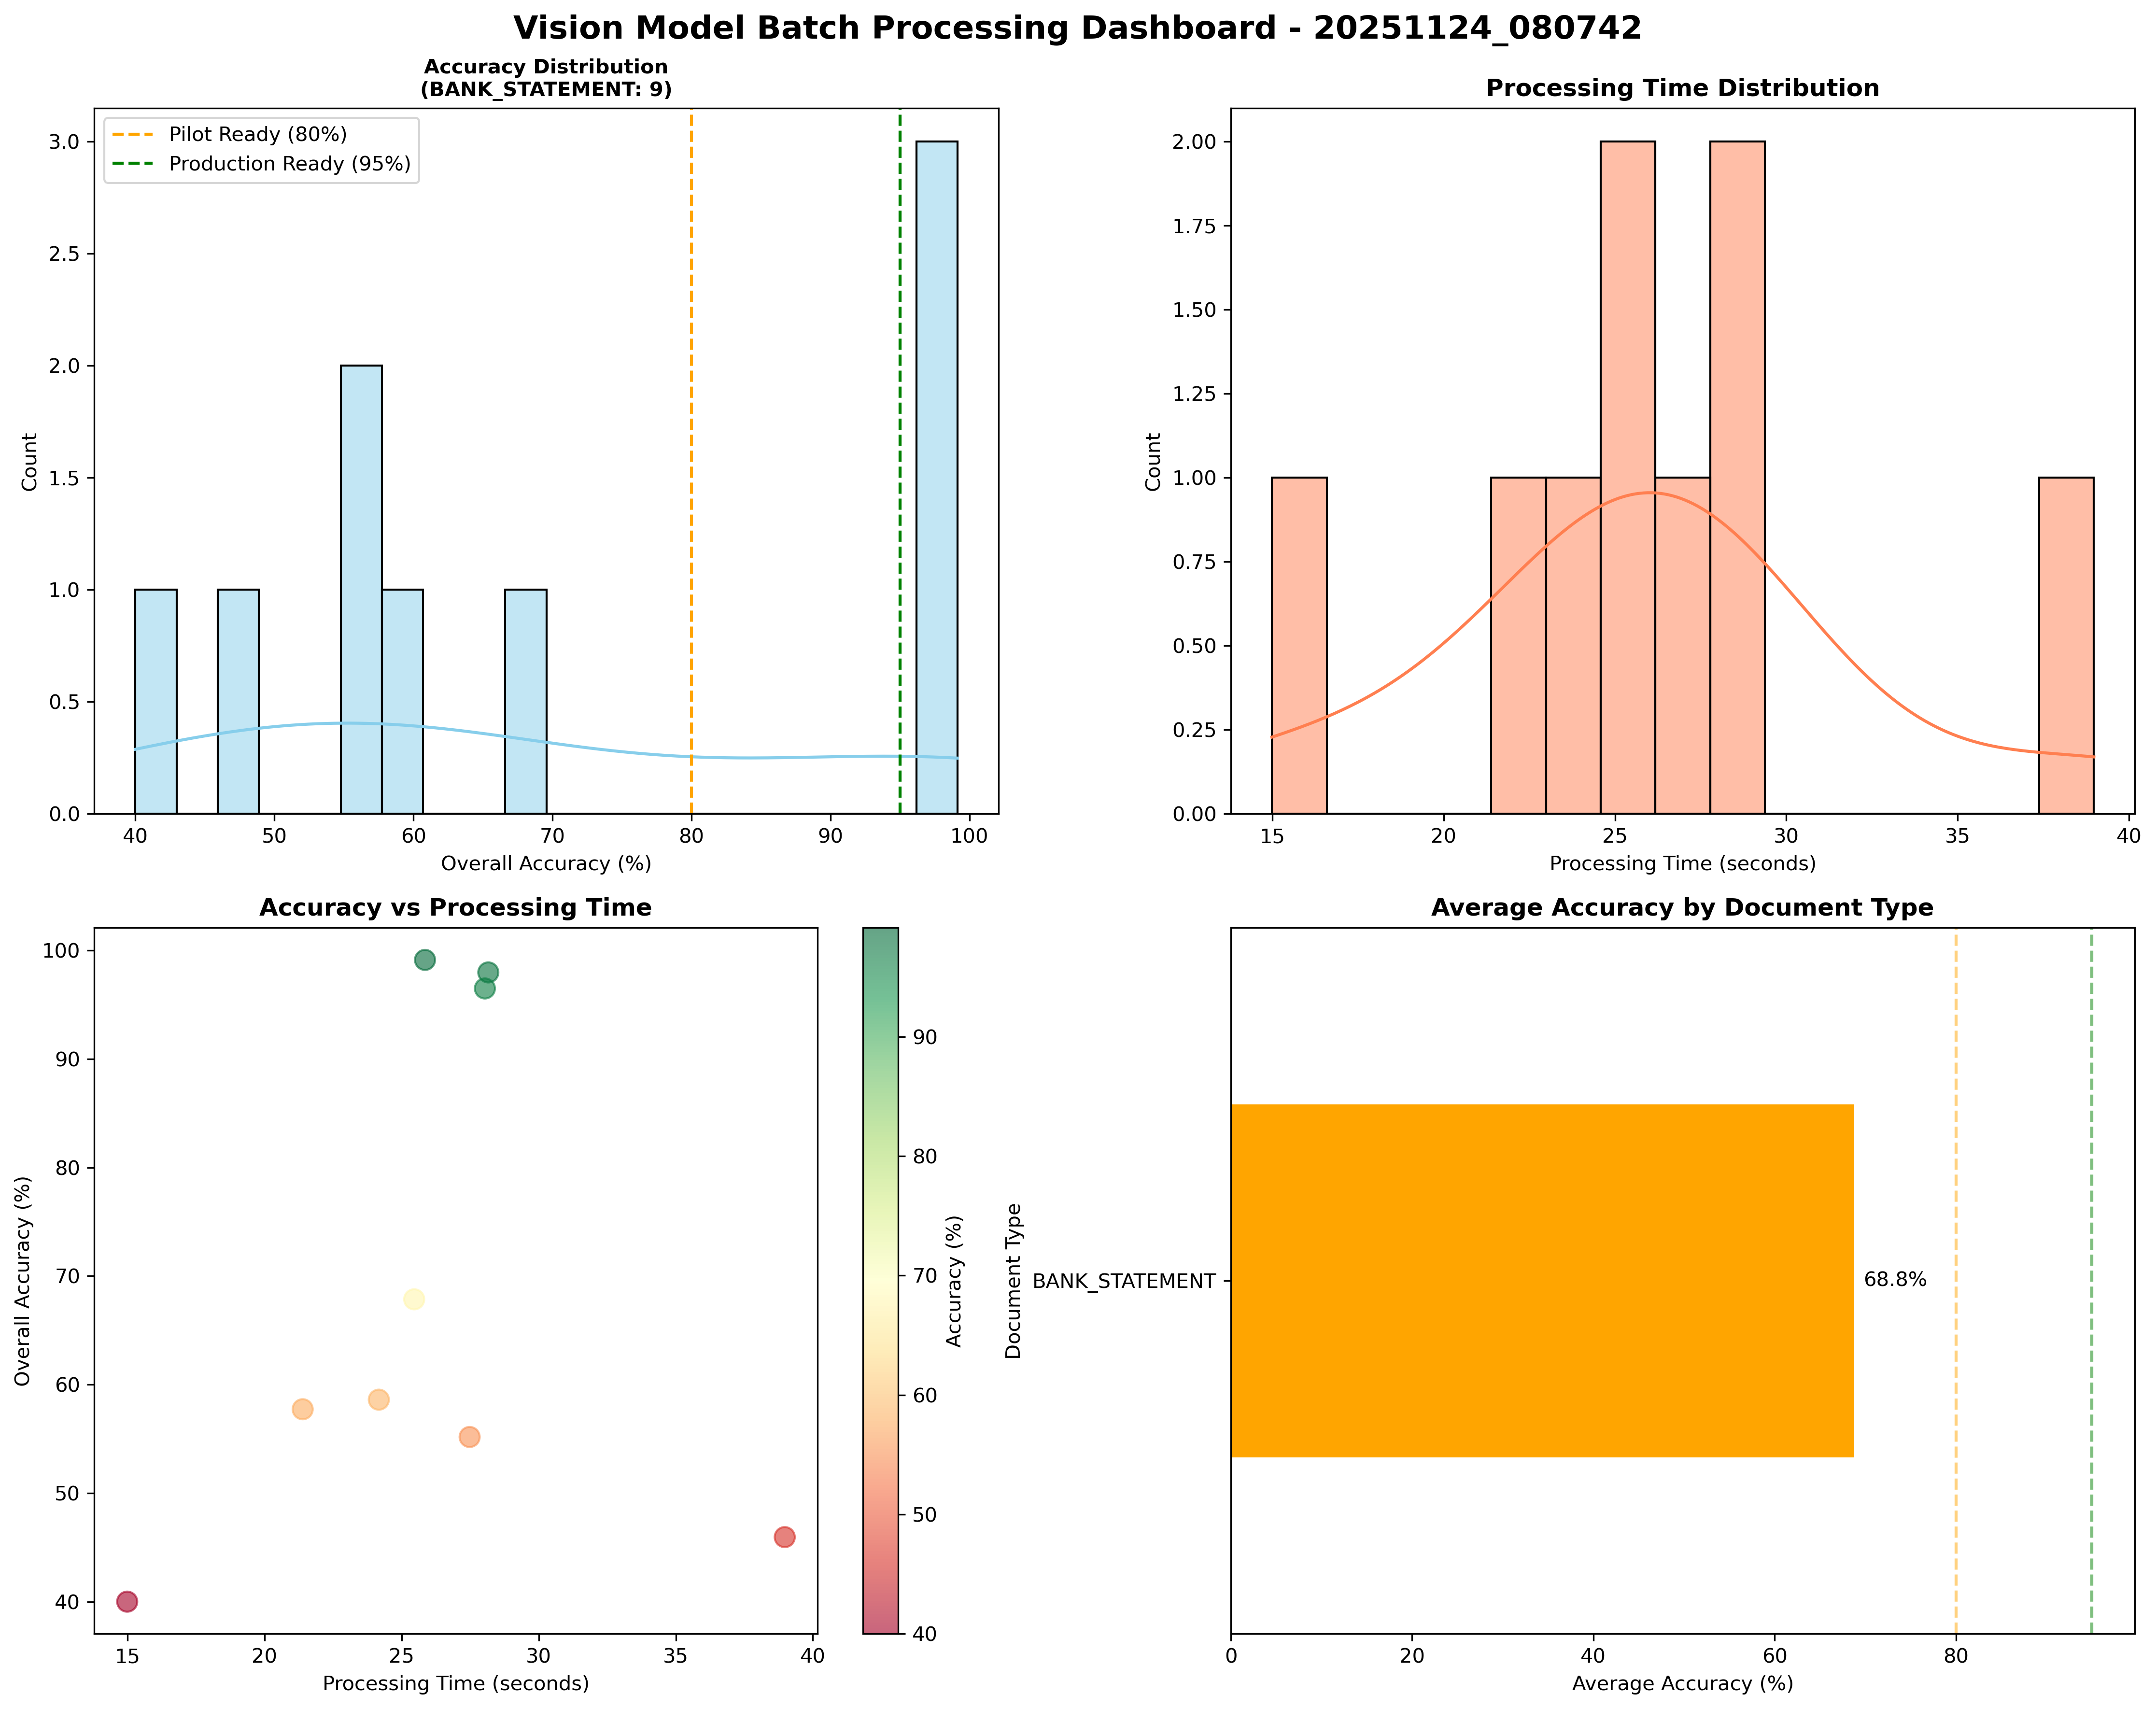

In [13]:
#Cell 12
# Display final summary
console.rule("[bold green]InternVL3.5-8B Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Overall Average Accuracy (across all images): {avg_accuracy:.2f}%[/cyan]")

# Show per-document-type breakdown
if len(df_results) > 0 and 'document_type' in df_results.columns:
    rprint("\n[bold blue]📊 Breakdown by Document Type:[/bold blue]")
    doc_type_stats = df_results.groupby('document_type').agg({
        'overall_accuracy': 'mean',
        'image_name': 'count'
    }).sort_values('overall_accuracy', ascending=False)
    
    for doc_type, row in doc_type_stats.iterrows():
        count = int(row['image_name'])
        acc = row['overall_accuracy']
        rprint(f"[cyan]  {doc_type.upper()}: {acc:.1f}% (n={count} images)[/cyan]")

rprint(f"\n[cyan]Output: {OUTPUT_BASE}[/cyan]")
rprint("[blue]🚀 Model: InternVL3.5-8B with Cascade RL and ViR[/blue]")

# Performance assessment
if successful == total_images and avg_accuracy > 50:
    rprint("\n[bold green]🎉 SUCCESS: InternVL3.5-8B processing completed successfully![/bold green]")
    rprint("[green]✅ Enhanced reasoning with Cascade RL is working[/green]")
    rprint("[green]✅ Dynamic resolution adjustment with ViR is active[/green]")
elif successful < total_images:
    rprint("\n[bold red]❌ FAILURE: Processing errors occurred[/bold red]")
    rprint("[red]🔍 Review error logs for diagnostic information[/red]")
elif avg_accuracy < 30:
    rprint("\n[bold yellow]⚠️ POOR PERFORMANCE: Low accuracy detected[/bold yellow]")
    rprint("[yellow]🔍 Review extraction results for quality issues[/yellow]")
else:
    rprint("\n[bold blue]📊 MIXED RESULTS: Partially working[/bold blue]")
    rprint("[blue]🔍 Review individual results to assess performance[/blue]")

# Document type distribution
if document_types_found:
    rprint("\n[bold blue]📋 Document Type Distribution:[/bold blue]")
    for doc_type, count in document_types_found.items():
        percentage = (count / total_images * 100) if total_images > 0 else 0
        rprint(f"[cyan]  {doc_type}: {count} documents ({percentage:.1f}%)[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    from IPython.display import Image, display
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

## 13. Failed Extractions

In [14]:
#Cell 13
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!